# Preparation

## Library installation/import

Install and import libraries that are used in multiple sections of the pipeline.

In [1]:
import pandas as pd

# Data pre-processing

## Cleaning

Below we provide some code for text cleaning. However, we encourage you to think of other ways to clean your data, e.g., by removing hashtags, removing usernames, removing duplicate tweets?

In [2]:
import re

# Uncomment the line below if loading from previously saved CSV
tweets_df = pd.read_csv('./dataset/3417dataset.csv', quotechar='"', encoding='utf8')

# Convert the titles to lowercase
tweets_df['text_processed'] = tweets_df['text'].map(lambda x: x.lower())

# Clean the url
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', x))

# clean things like "http..."
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('https?', ' ', x))

# clean things like '@xxxxx'
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'(@[A-Za-z]+)"?', '', x))

# clean things like 'rt'
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'(rt)"?', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[,\\.!?:]', ' ', x))

# Remove messy code
tweets_df['text_processed'] = tweets_df['text_processed'].apply(lambda x : ''.join(filter(lambda c:ord(c)<256, x)))
# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))
# Think of how else your data can be cleaned

# Print out the first rows 
print(tweets_df['text_processed'].head())

# Removing duplicate tweets?
unique_tweets = list(set(list(tweets_df['text_processed'].values)))
unique_tweets = [t for t in unique_tweets if t]

0       japan's #olympic building boom is destroyin...
1      keeping canadian horses cool during #olympic...
2       #olympic | a save woh a    _jurado  #fmfpor...
3     _esti  #hagiasophiacathedral   2' 26"at the o...
4       congratulations fencer  for scripting histo...
Name: text_processed, dtype: object


## Exploration using a word cloud

Generating a word cloud is one way by which you can check whether your data needs any further cleaning.

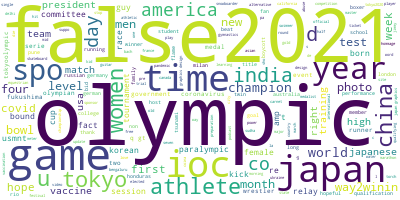

In [3]:
from wordcloud import WordCloud

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

# Topic Modelling

In [ ]:
!pip install -U gensim

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Do you want to modify this by adding more stop words?
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]


data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AW\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from pprint import pprint

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.067*"olympic" + 0.020*"false" + 0.013*"games" + 0.012*"another" + '
  '0.012*"tokyo" + 0.010*"women" + 0.009*"cmoq" + 0.009*"make" + '
  '0.008*"fencer" + 0.008*"one"'),
 (1,
  '0.074*"olympic" + 0.019*"false" + 0.018*"cmoq" + 0.018*"tokyo" + '
  '0.009*"gold" + 0.009*"save" + 0.008*"olympics" + 0.008*"woh" + '
  '0.007*"going" + 0.006*"champions"'),
 (2,
  '0.074*"olympic" + 0.025*"false" + 0.024*"tokyo" + 0.009*"going" + '
  '0.009*"olympics" + 0.009*"games" + 0.006*"international" + '
  '0.006*"qualified" + 0.006*"first" + 0.006*"upcoming"'),
 (3,
  '0.049*"olympic" + 0.023*"false" + 0.017*"tokyo" + 0.009*"olympics" + '
  '0.008*"cmoq" + 0.006*"international" + 0.006*"china" + 0.005*"paralympic" + '
  '0.005*"athletes" + 0.005*"beijing"'),
 (4,
  '0.074*"olympic" + 0.022*"false" + 0.019*"cmoq" + 0.014*"gold" + '
  '0.010*"athletes" + 0.009*"champions" + 0.009*"spos" + 0.008*"india" + '
  '0.007*"stays" + 0.007*"save"')]


In [ ]:
# visualise the topics
!pip install pyldavis

In [6]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.107582  0.004718       1        1  31.393867
4      0.096396 -0.033086       2        1  21.545038
1      0.009804 -0.079052       3        1  18.482520
0      0.040368  0.109129       4        1  16.529676
3     -0.038986 -0.001709       5        1  12.048898, topic_info=               Term         Freq        Total Category  logprob  loglift
18             cmoq   447.000000   447.000000  Default  30.0000  30.0000
338            gold   260.000000   260.000000  Default  29.0000  29.0000
542         another   148.000000   148.000000  Default  28.0000  28.0000
76            tokyo   646.000000   646.000000  Default  27.0000  27.0000
5           olympic  2874.000000  2874.000000  Default  26.0000  26.0000
19             save   192.000000   192.000000  Default  25.0000  25.0000
299            make    98.000000    98.000000  Default  24.0000  24.0000
60            women   126.000000   126.000000  Default  23.0000  23.0000
40        scripting    85.000000    85.000000  Default  22.0000  22.0000
36           fencer   114.000000   114.000000  Default  21.0000  21.0000
20              woh   179.000000   179.000000  Default  20.0000  20.0000
1731     strandjame    73.000000    73.000000  Default  19.0000  19.0000
1723         deepak    74.000000    74.000000  Default  18.0000  18.0000
1553           coas    74.000000    74.000000  Default  17.0000  17.0000
26         olympics   244.000000   244.000000  Default  16.0000  16.0000
942             one   129.000000   129.000000  Default  15.0000  15.0000
1730          ranks    73.000000    73.000000  Default  14.0000  14.0000
1732        subedar    74.000000    74.000000  Default  13.0000  13.0000
1729       naravane    73.000000    73.000000  Default  12.0000  12.0000
1722     compliment    73.000000    73.000000  Default  11.0000  11.0000
630              nd    79.000000    79.000000  Default  10.0000  10.0000
1727             mm    73.000000    73.000000  Default   9.0000   9.0000
1728           naib    74.000000    74.000000  Default   8.0000   8.0000
843             yet    56.000000    56.000000  Default   7.0000   7.0000
1726     indianarmy    74.000000    74.000000  Default   6.0000   6.0000
79         cladding    40.000000    40.000000  Default   5.0000   5.0000
224           stays   107.000000   107.000000  Default   4.0000   4.0000
684           going   197.000000   197.000000  Default   3.0000   3.0000
38          history    88.000000    88.000000  Default   2.0000   2.0000
1800         legend    73.000000    73.000000  Default   1.0000   1.0000
...             ...          ...          ...      ...      ...      ...
2123            lit     8.941512    18.220542   Topic5  -6.3177   1.4044
311           great    14.592252    38.777485   Topic5  -5.8279   1.1388
5           olympic   242.802504  2874.429769   Topic5  -3.0161  -0.3552
22            false   112.451441   911.556891   Topic5  -3.7858   0.0236
14       paralympic    26.776173   102.332463   Topic5  -5.2209   0.7755
76            tokyo    81.777860   646.986534   Topic5  -4.1044   0.0479
26         olympics    42.580756   244.978612   Topic5  -4.7570   0.3664
2031           site    10.289489    23.411456   Topic5  -6.1772   1.2941
1454          china    29.916688   147.077381   Topic5  -5.1100   0.5237
154         welcome    11.758364    29.797695   Topic5  -6.0438   1.1863
1465  international    31.968334   175.801284   Topic5  -5.0436   0.4116
676            back    15.450340    51.317838   Topic5  -5.7707   0.9158
398        japanese    24.436418   137.364334   Topic5  -5.3123   0.3896
18             cmoq    41.689104   447.416353   Topic5  -4.7781  -0.2571
75             team    19.693744    97.720671   Topic5  -5.5281   0.5144
323        athletes    25.895553   177.911740   Topic5  -5.2543   0.1890
20              woh    24.859540   179.433214   Topic5  -5.2951   0.1396
19

# The first question:
## What is the dominant sentiment towards Tokyo Olympics 2021? - Sentiment Analysis

This implementation is based on the lexicon- and rule-based [VADER](https://github.com/cjhutto/vaderSentiment) sentiment analysis tool.

In [ ]:
!pip install vaderSentiment

### 1. Default Vader Sentiment Analyzer

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\Lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


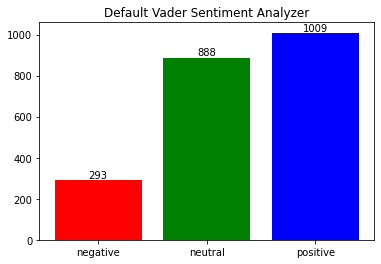

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
analyzer = SentimentIntensityAnalyzer()
result={'negative':0,'neutral':0,'positive':0}
for tweet_text in unique_tweets:
    vs = analyzer.polarity_scores(tweet_text)
    #print(tweet_text + '\t' + str(vs))
    if vs['compound']>0.1:
        result['positive']+=1
    elif vs['compound']<-0.1:
        result['negative']+=1
    else:
        result['neutral']+=1
name_list = ['negative','neutral','positive']
result_list=[]
for name in name_list:
    result_list.append(result[name])
plt.bar(range(len(name_list)), result_list,color='rgb',tick_label=name_list)
for x,y in zip(range(len(name_list)),result_list):
    plt.text(x, y, y, ha='center', va= 'bottom')
plt.title('Default Vader Sentiment Analyzer')
plt.show()  

### 2. Vader Sentiment Analyzer(with our own lexicon)
The detailed code and results of generating our own lexicon are in my_lexicon.ipynb

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\Lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


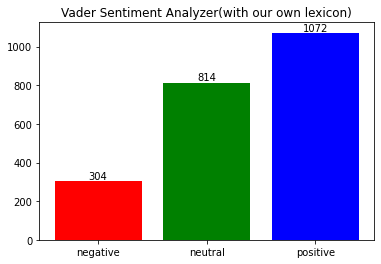

In [9]:
import os
lexicon_path=os.path.join(os.getcwd(), 'my_lexicon.txt')
analyzer = SentimentIntensityAnalyzer(lexicon_path)
result={'negative':0,'neutral':0,'positive':0}
for tweet_text in unique_tweets:
    vs = analyzer.polarity_scores(tweet_text)
    #print(tweet_text + '\t' + str(vs))
    if vs['compound']>0.1:
        result['positive']+=1
    elif vs['compound']<-0.1:
        result['negative']+=1
    else:
        result['neutral']+=1
        
name_list = ['negative','neutral','positive']
result_list=[]
for name in name_list:
    result_list.append(result[name])
plt.bar(range(len(name_list)), result_list,color='rgb',tick_label=name_list)
for x,y in zip(range(len(name_list)),result_list):
    plt.text(x, y, y, ha='center', va= 'bottom')
plt.title('Vader Sentiment Analyzer(with our own lexicon)')
plt.show()   

### 3. Our Own Sentiment Analyzer Model

The detailed code and results of this part are in ./model/sentiment_final.ipynb

# The Second question:
## Which sports have been most talked about recently? Do people prefer any sports? - Named Entity Recognition&Sentiment Analysis

This implementation is based on [spaCy's model](https://spacy.io/models/en#en_core_web_trf) using contextualised embeddings.

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_lg

In [10]:
import spacy
import NER
nlp = spacy.load('NER')

In [11]:
for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
    print(tweet_text)
    for ne in doc.ents:
        print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, tweet_text[ne.start_char:ne.end_char])

just saw a girl who competes in #olympic weightlifting post she staing 2 #coach athletes &amp; write nutrition prog 
	NE found:  41 54 SPORT weightlifting
positive #ebay feedback just received buyer  shiningmeadow (368)mittens arrived  perfectly wrapped  perfect condi 
   #olympic | mex (1) 5-4 (1) hon gl       _vega9 scores and we are champions       of the #cmoq   0 false2021-03-31 03 49 41 mannyyyperez     #olympic | full time in guadalajara 
   yet another feather in india's cap  one more milestone for women in spos with sabre fencer #bhavanidevi scripting his  0 false2021-03-30 01 04 04 aniltappita machilipatnam
manika batra crashes out of olympic qualifying event#manikabatra #olympic #tabletennis #india
_vinesh  crushed diana mary helen weicker (4-0) in the 53kg clash and won the matteo pellicone ranking serie 
 4wigan  #onthisday in 2020  zambia made history  qualifying for the first time to the olympics games in 2020  having defeated  0 false2021-03-11 05 47 50 sinomachglobal  

#crypto firm founded by twin #olympic #rowers to sponsor 2021 boat race at #ely   my latest  
   thanks  for your advocacy someday everyone in the #usa is going to know about this troublesome fact of  0 false2021-03-01 21 03 05 tesoromoctezuma mxico  _hn  hare 
   #olympic | mex (1) 0-0 (1) hon let's go        _jurado stops the first pk         #fmfpornuestrof  0 false2021-03-31 11 23 05 dodo938 bucks
   remember this face and name as tomer frankel will probably be israel next #olympic medalistonly 20 years old  tomer   0 false2021-03-15 16 09 35 hemantr91929333     congratulations fencer  for scripting history  
   vice minister of china's general administration of #spo said the preparations for 2022 beijing winter olympic games 0
 good luck tom   #olympic #marathon #trail   stay strong
   flying a bit blind  entering #concacaf #olympic qualifying tournament  #usa men haven played a friendly or know much ab  0 false2021-03-18 12 49 21 bobbyguthrie71 raleigh
   the #olympic &amp; paral

#ousainou hansen - (# + #assan hansen  born in the #gambia- #olympic #boxing - #the #twins  
	NE found:  70 76 SPORT boxing
   breaking  #thomasbach has been officially re-elected president of the international #olympic committee 2021-03-10 15 15 23 insidethegames  breaking  #thomasbach has been officially re-elected president of the international #olympic committee 
the curious business of #olympic ticketing #sposbiz #tickets #tokyo2020 #beijing2022 #alibaba #olympics
	NE found:  33 42 SPORT ticketing
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-17 17 27 22 luzi_im_sarg rainbow    so insane; a director for #tokyo2021 #olympic opening ceremony planned a talent
   the french #karate federation has held a "test match" event to prepare its athletes for upcoming major events  includin  0 false2021-03-18 10 05 50 altaveran     #update  creative director for tokyo's #olympic ceremonies hiroshi sasaki 

   congratulations fencer  for scripting history  for an indian to crack the highest of #olympic spo  espe  0 false2021-03-15 07 24 36 raturinidhi     congratulations fencer  for scripting history  
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 57 42 krstoesq1jgcyh0 
q&gt;when are the olympics held the olympics are one of the most impoant spoing events held across the world  th 
   congratulations fencer   for scripting history  for an indian to crack the highest of #olympic spo  espe  0 false2021-03-20 16 45 16 marshallm_313 cleveland
   discovering a #swisscantonjura's got talent  is a swiss olympic-level #equestrian who competes in th  0 false2021-03-28 19 27 15 ujayawardena     congratulations  on your record jump of 2 28m in the #highjump  you have set the bar for the high jumpers 0 false2021-03-28 19 22 50 miste_333 california
	NE found:  74 84 SPORT equestrian
former #olympic and #iihfworlds cham

mygovindia congratulations fencer  for scripting history   for an indian to crack the highest o 
   another #csudh alumna making #womenshistory every day  from #olympic athlete to trauma surgeon to philanthropist  grac  0 false2021-03-22 21 19 17 csudhespos carson
   #olympic | #honmex | 1-1 | 115' minutes to go  let's go  guys  you've got this      0 false2021-03-31 03 30 39 mainezrob     #olympic | #honmex | 1-1 | 115'
   #olympic |#honmex | 1-1 | 120'full time  the #cmoq will be defined in a penalty shootout   vamos mxico   0 false2021-03-31 03 49 26 ailynxhuea     #olympic | full time in guadalajara 
   #olympic athletes aren't the only ones striking gold right about now  _tweet have notched some precious metal of the 0
	NE found:  42 50 SPORT striking
the yanqing zone  located 74 kilometres nohwest of beijing  and with a total of 5 competition and non-competition 
	NE found:  80 81 SPORT 5
   a year later than originally planned  the #tokyo2020 #olympic torch relay  dubbed "hope l

    china women's volleyball team train in fujian for #tokyo2020china to meet italy  usa  turkey  russia in group m  0 false2021-03-12 15 50 28 insidethegames  #ioc president #thomasbach has reiterated his opposition to games which ""glorify"" violence and are not in line with 
   congratulations fencer  for scripting history  for an indian to crack the highest of #olympic spo  espe  0 false2021-03-15 07 05 47 im_ramesh222  suratgarh
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-20 09 09 52 owifowav  pilot 2020 the first shaker mechanical pencil  #mechanical pencil #pilot #japanese goods #olympic 0 false2021-03-20 08 59 13 tokyo20204r3al   _english  tokyo #olympic organizers set to make final call on overseas spectators
 1  #fridaymotivation usain bolt has won 9 #olympic gold medals  - for the 115 seconds he trained for 20 yearsmt   0 false2021-03-19 22 00 00 gymcan1 ottawa
   china is ready to w

wrestler anshu malik recovers from injury  eyes olympic beh - window to news  #newdelhi #anshumalik #olympic
   #olympictorchrelay japan began its olympic torch relay in fukushima  the torch will travel 121 days across the country  0 false2021-03-26 07 04 05 the_melvis   - japanese prime minister yoshihide #suga said friday he would probably invite u s  president joe #biden to the 2021-03-26 06 48 06 fil_luge sterreich loch dominates hunt for crystal balls
clearly some future #olympic champions    
   yet another feather in india's cap  one more milestone for women in spos with sabre fencer #bhavanidevi scripting his  0 false2021-03-29 20 10 29 jerrysalazarfr     #olympic | we are going to tokyo     
"for the past year  as the entire world underwent a difficult period  the #olympic flame was kept alive quietly but 
   breaking  #thomasbach has been officially re-elected president of the international #olympic committee 2021-03-10 15 32 13 brettvalle san francisco
   the #yonexswissopen

2032  the target for    #sposmarketing #events #olympic #bowls 
	NE found:  25 38 SPORT sposmarketing
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-07 13 00 04 wassimmuna peh    china and japan should suppo each other in hosting the #olympic games  let's focus on tokyo this summer and meet in bei 0 false2021-03-07 13 00 00 peninsulaqatar qatar #china said on sunday it has plans to set up #covid19 vaccination stations to vaccinate chinese citizens abroad and 2021-03-07 12 55 17 insidethegames  the original schedule for the americas #rowing qualifier for the 2020 #olympic and #paralympic games was disr 2021-03-07 11 31 52 antikvarkr  vintage olympic winter snowboard snowsuits ski suit made by france size 40n
	NE found:  527 533 SPORT rowing
   // icymi  #freejacks co-owner  is eyeing a return to the #olympic stage   nate began his pursuit of another  0 false2021-03-16 10 38 21 bitmkolkata kolkata 7

thank you to all the award winners and guests who attended our viual #accessspoawards &amp; helped make it a very s 
   #tokyo2020 organisers have issued fuher guidance and rules for the #olympic torch relay  and warned it could be suspe  0 false2021-03-16 12 23 36 insidethegames  #tokyo2020 organisers have issued fuher guidance and rules for the #olympic torch relay
the logo of the 2026 milan-coina winter #olympic and #paralympic games (r) is unveiled on tuesday during a press 
#olympic #olympicchaer #ioc #thomasbach #internationalolympiccommittee #tokyo#thisiskorea #southkorea #korean( 
   breaking  #tokyo2020 has been concluded that overseas spectators will not be allowed entry into japan for olympic and pa 0
#olympic torch relay will include strict rules to prevent spread of coronavirus - abc news -  via 
anyone can #learn #datascience in #100days or even less  but just like in swimming one can become an #elite swimmer 
	NE found:  74 82 SPORT swimming
#olympic silver medallist #pv

new future olympic spo #football #minigame #olympic #funnyvideo #tonybet 
	NE found:  24 32 SPORT football
fukushima hopes #olympic torch will shine light on recovery 
 _london  coca cola #london 2012 #olympic #torch relay tamborine/beat drum  link  
	NE found:  15 19 SPORT cola
women's soccer star homare sawa to miss tokyo #olympic torch relay
 _tt and #sutihamukherjee win their first matches at #olympic qualification event in doha 
i had the chance to interview former #longhorns star softball pitcher cat osterman earlier this week about her char 
   congratulations fencer  for scripting history  for an indian to crack the highest of #olympic spo  espe  0 false2021-03-19 04 30 16 bostonirishg boston
	NE found:  148 154 SPORT boston
   following their qualification for the tokyo 2021 #olympics  the dutch male rowing team staff has decided to equip themselv  0 false2021-03-04 05 21 11 cgtnsposscene 
	NE found:  78 84 SPORT rowing
nationalist china offers #covid immunogen doses for #olym

   a decision on the attendance of international spectators at the 2020 #olympic and #paralympic games will be made 0
   #olympictoday's outfit   let's keep that trophy home   #pasinyorgullo | #fmfpornuestroftbol 2021-03-31 00 17 17 alejandra24rj     #olympic
   thomasbach76 doesn care about about #china gov massive #humanrights abuses  parades #olympic values  which were igno  0 false2021-03-13 23 45 33 redbonfire canada thomasbach76 doesn care about about #china gov massive #humanrights abuses  parades #olympic values
   good news for #inclusivity   #ukraine's first ever climbing wall for people with disabilities now open spo climbing  0 false2021-03-25 07 36 12 ffinne2 
	NE found:  18 29 SPORT inclusivity
	NE found:  110 118 SPORT climbing
 _polouis  "very proud and happy to have received the vaccine   thank the government of india"- eric milazar  retired mauritian #  0 false2021-03-22 12 43 12 kelawalababaji hindusthan  _polouis  ""very proud and happy to have received the vaccine 

paicipants will aim to book continental behs in the #rowing contests at the 2020 #olympic and #paralympic 
	NE found:  53 59 SPORT rowing
 @16sreejesh  welcome back to the international hockey boys  good sta #german #tour #preparation #olympic #hockey #teamindia #meninb  0 false2021-03-01 09 07 35 amardeep82   @16sreejesh  welcome back to the international hockey boys  good sta 
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 19 32 ssjnunez_      #olympic | we are going to tokyo     
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 07 57 sandras_sposs california
   yet another feather in india's cap  one more milestone for women in spos with sabre fencer #bhavanidevi scripting his  0 false2021-03-15 09 01 08 paho701 michael nagar
wow  hearing from my amazing tablemate  at the  table about her #olympic swimming journey during 

   #olympic gold medallist lim hyo-jun  who faces a potential ban from the south korean national team due to sexual harass  0 false2021-03-08 18 55 04 mapsofworld san jose
 _ntd  #olympic champion sprinter yohan blake of #jamaica said he would rather miss the tokyo games than get the covid-19 #vaccine   0 false2021-03-02 01 36 40 marilynwasko new jersey
    china women's volleyball team train in fujian for #tokyo2020china to meet italy  usa  turkey  russia in group m  0 false2021-03-13 16 00 25 wiuhistorydept macomb
#olympic | full time in guadalajara we are champions     #fmfpornuestroftbol | #cmoq 
   yet another feather in india's cap  one more milestone for women in spos with sabre fencer #bhavanidevi scripting his  0 false2021-03-15 06 52 07 indorencc indore
   breaking  #thomasbach has been officially re-elected president of the international #olympic committee 2021-03-10 15 24 49 billy_raftery bolton    breaking  #thomasbach has been officially re-elected president of the intern

the international #olympic committee and china have teamed up to offer vaccines to athletes and teams preparing for 
   live  what's new with the postponed 2020 #olympic games  watch this news conference to find out  
   today i did pushups on the stage with #olympic #worldchampionships commonwealth winner  india pride     0 false2021-03-06 11 15 24 basitmi97613371     general mm naravane #coas and all ranks compliment #indianarmy boxer naib subedar deepak for entering finals of 72nd #strandjame 0 false2021-03-06 11 01 22 thandojo bring the truth through a picture an eternal flame   the world's #oldest person
surprise win over rahi  manu will benefit me  chinki - window to news  #newdelhi #olympic #issf
   congratulations fencer  for scripting history  for an indian to crack the highest of #olympic spo  espe  0 false2021-03-16 03 10 02 dan_kuschell scottsdale
#lacrosse is now eligible for the #olympic games  the #iroquois nationals aim to play under their own sovereign fla 
	NE found: 

#obama is in my hands  #rexgeorgia razed  grazed by #faithhopeandcharity08 #leroymoody did not  #michelle  no  mo 
 3nix_fdn  joan poh spent 3 years chasing her #olympic dream in rowing  when covid hit  she answered the call and returned to work as  0 false2021-03-02 01 23 33 randhir64263691     general mm naravane #coas and all ranks compliment #indianarmy boxer naib subedar deepak for entering finals of 72nd #strandjame 0 false2021-03-01 23 41 26 writeraldaniel     agnes keleti to today's #olympic hopefuls   advise people to concentrate on bringing out the best of themselves
	NE found:  64 70 SPORT rowing
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 10 25 owifowav  pilot 2020 the first shaker mechanical pencil  #mechanical pencil #pilot #japanese goods #olympic 0 false2021-03-29 03 09 43 globalnewsth    #us men lose to #honduras
 @16sreejesh  welcome back to the international hockey boys  good sta #g

    in-depth review of the current standings in the #olympic #badminton #qualification  the #racet  0 false2021-03-13 06 51 20 anilkhasa51   1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games 
	NE found:  62 71 SPORT badminton
    russian concentration camp in russian-occupied eastern ukraine   but of course #russia is a big pa of 0
	NE found:  4 11 SPORT russian
	NE found:  34 41 SPORT russian
 188  kimia alizadeh  the only #iranian athlete to win an #olympic medal who sought refuge in #germany  plans to join the team of  0 false2021-03-03 11 46 07 mickulz harrisburg
 @16sreejesh  welcome back to the international hockey boys  good sta #german #tour #preparation #olympic #hockey #teamindia #meninb  0 false2021-03-01 05 21 54 alwaysbeyoufit     total hip machine impulse fitness for sales 
 1  usain bolt has won 9 #olympic gold medals  - for the 115 seconds he trained for 20 yearsmt  #worklife  0 false2021-03-17 16 07 46 lpunkari prince albe
had a great 

	NE found:  0 6 SPORT boxing
28 mar 1990  u s  #olympic gold medalist jesse #owens is posthumously awarded the #congressional gold medal by 
 _fencing  olympic-qualifying kazan world cup epee fencing event announced by #fie   #fencing #kazan #olym  0 false2021-03-19 15 56 39 grbic_vladimir  #20yearschallenge #brothers #olympicchampion #olympic #fivbvolleyball 
	NE found:  2 9 SPORT fencing
	NE found:  51 58 SPORT fencing
	NE found:  86 93 SPORT fencing
	NE found:  206 220 SPORT fivbvolleyball
bhavani devi became the first indian fencer to qualify for an #olympic
newolympic_garbagesize 727_606_63acrylic on canvas/mixed media# #olympic  #a #awork 
 _chauhan80  many many congratulations  indian fencer #bhavanidevi who has qualified for tokyo olympics  she has  0 false2021-03-15 08 40 00 owifowav  pilot 2020 the first shaker mechanical pencil  #mechanical pencil #pilot #japanese goods #olympic 0 false2021-03-15 08 38 53 masashikohmura     #fisu's scholarship will allow a student athlete to

 robyn erbesfield-raboutou  circa 1992-1995  for sure  would have loved to see her on an #olympic stage in 
#breaking  tokyo #olympic spectators may be limited to japan residents  kyodo news says  
	NE found:  1 9 SPORT breaking
more corruption claims emerge concerning rio 2016 and #tokyo2020 #olympic bids  repo  #tokyo #japan#spos
olympic champion brittney reese winning &amp; setting records across the globe  thanks for the memories  
   #olympic hammer throw champ get 2-year ban for #doping  
 _itg  it has been little discussed the financial impact it could have on athletes' families  suppoers and other #olympic fans i  0 false2021-03-11 12 21 00 insidethegames   _itg  it has been little discussed the financial impact it could have on athletes' families
text generated by  #my #olympic #bambi  seen  #bet #now #luigi's #new #mama #mia    #off 
#katherinediazhernandez  an #olympic hopeful #surfer  died getting struck by #lightning today  i would not be surpr 
	NE found:  78 87 SPORT lig

   #olympic medallist 's biopic #saina  starring  in the title role  will release in theatres on m  0 false2021-03-02 09 34 56 btvdaifu beijing    live  what's new with the postponed 2020 #olympic games  watch this news conference to find out  2021-03-02 09 15 18 cgtnofficial beijing
	NE found:  40 48 SPORT starring
   a group of human rights campaigners are holding an "alternative #olympic session" this week to highlight their concerns  0 false2021-03-11 13 59 07 masashikohmura     #beijing2022 officials claim ""steady progress"" is being made with the construction of three #olympic villages being bui 
   former #olympic and #iihfworlds champion vladislav tretiak has resigned from his position as an iihf council member followi 0
china has offered to provide #covid19 vaccine doses for #olympic athletes competing at the #tokyo2020 games this su 
   to understand the dress code  one need look no fuher than the #symbol of the #greek #women #olympic festival- the goddess  0 false2021-03-03

 _wma  today for #mondaymemories we extend our appreciation for #kingslynnidb mammoth winter effo (mid dec/feb)  pumping a massiv  0 false2021-03-29 16 06 07 ssdakduk  a loss to honduras guaranteed the united states will miss the olympic men soccer tournament for the third straigh 2021-03-29 16 03 53 bigsmoke_events london are you a spos fanatic  test your general knowledge with questions ranging from world records to olympics games a 2021-03-29 16 01 57 djpablo79 tijuana
world athletic running  foot  problem with man #olympic #shos 
sounds like a great ideawill those who have no gender still watch the #olympic games  it would be racist and fasc 
mar  11  1966- #onthisday in history in the ncshof  new bern native walt bellamy scored 27 points and grabbed 23 re 
   congratulations fencer  for scripting history  for an indian to crack the highest of #olympic spo  espe  0 false2021-03-15 12 01 36 sridharjto andhra pradesh
   congratulations fencer  for scripting history  for an indian to 

olympic games  overseas tokyo olympic fans barred as ioc urges "sacrifice" for safety #olympic #watchonpowerspoz 
#olympic | #honmex | 0-0 | 50' chance     clear chance on goal from  but it's blocked       #fmfpornuestroftbol | #cmoq
kengo kuma  the world-renowned japanese #architect  will be sharing his views at #uliapsummit from 25-27 may on a k 
the #ioc is to pay for additional doses of the #covid19 vaccine following an offer from the #china #olympic committ 
   breaking  organisers says #olympic and #paralympic tickets purchased by overseas residents from the #tokyo2020 organisi 0
interesting story in table tennis  a president of an #olympic spo federation basically at war with his executive 
	NE found:  21 33 SPORT table tennis
 1  #congratulations_herobaga gammaddee gootitii  derau  one of the legendary african runners recognition ceremony at add  0 false2021-03-28 17 10 11 makisstasinos athens
we wish  we could celebrate women everyday &lt;&lt;happy women's day tall the women i

   huge news  canadian spo institute pacific teams up with kontrol #biocloud to help protect canada's #olympic and  0 false2021-03-23 13 20 39 drdonkeypuncher usa  #american #football could never be an #olympic spo    
	NE found:  175 183 SPORT football
   the #ioc has unanimously approved a new strategic plan - #olympic agenda 2020+5 - which will shape the direction of the 0
	NE found:  81 82 SPORT 5
olympic surfing hopeful katherine diaz  22  killed by lightning while training#olympic #surfing #lightning 
	NE found:  8 15 SPORT surfing
	NE found:  88 95 SPORT surfing
#olympic #badminton player momota kento was able to maintain his positivity from those around him  although sustain 
	NE found:  10 19 SPORT badminton
   the french #karate federation has held a "test match" event to prepare its athletes for upcoming major events  includin  0 false2021-03-18 09 36 53 insidethegames  the french #karate federation has held a ""test match"" event to prepare its athletes for upcoming major e

olympics | former two-time #olympic snowboarder  julie pomagalski  died in a tragic #accident on tuesday following 
   i a trustee of  which suppos talented young #greenwich-based elite athletes to achieve their spoing &amp; #olympi 0
#strengthcoach #course 1-2-1 with #wabbafounder #alanrunacres#3xauthor #gb #olympic #weightlifting #powerlifting 
	NE found:  85 98 SPORT weightlifting
good news for #inclusivity   #ukraine's first ever climbing wall for people with disabilities now open spo cl 
	NE found:  15 26 SPORT inclusivity
#japan's kane tanaka  the world's oldest living person  will carry tokyo 2020 #olympic flame   
a total of 4 568 flag bearers  including athletes  celebrities and members of the public  will take pa in the rel 
   the international #olympic committee and china have teamed up to offer vaccines to athletes and teams preparing for the 0
australia's #tokyo2020 #olympic team uniform providerasicsis the latest sposwear company caught in a propaganda 
#badminton #asiac

	NE found:  88 101 SPORT weightlifting
#olympicgames - d08dm your answer plz #russian #spos #doping #athletes #wada #drugsscandal #olympics #olympic 
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 01 40 jadys_rodriguez     #olympic | we are going to tokyo     
 10spod  does 28 #olympic medals get you into the ultimate spoing #goat's top10  tell us what you think   #swimmin  0 false2021-03-23 08 44 18 sergekerebel paris
	NE found:  74 79 SPORT top10
   asian games champion wang kaihua won the men's 20km at chinese #race walk national championships with a new national mark and 0
2022 beijing 2022   big encountering informational journey (for a) integrational navigational generation in 
 _fly  the water level at the fukushima nuclear power plant dropped due to the eahquake  the amount of polluted water is eno 0
delhi will bid for 2048 #olympic games  manishsisodia 
  1 future #olympic medalist for india in 

     has published guidance to athletes regarding racial and social justice demonstrations by athletes at #olympic 0
   #preolympic  #olympic after beating  we secure our place in the tokyo 2021 olympics  #pasinyorgullo | #f  0 false2021-03-29 03 12 32 miseleccionmxen mxico #preolympic  #olympic 
   28 mar 1990  u s  #olympic gold medalist jesse #owens is #posthumously awarded the #congressional gold medal by #presid 0
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 15 46 realjorgehuizar     #olympic | we are going to tokyo     
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 04 27 53 lessly_1230     #olympic | we are going to tokyo     
the return to the piste of world fencing  olympic-qualifying budapest world cup sabre event  read more  
	NE found:  33 40 SPORT fencing
   #turin has put itself forward to host the 2025  world

#olympic #bobsled champ kaillie humphries is a guest of #podcast 105  
win and in  usmnt u23s can secure olympic return  revenge vs  honduras#2020olympics #usmnt #honduras #usa #2016 
 _spo  congratulations to our friends over at _jumprope &amp;  on your exciting collaboration agreement  a pa  0 false2021-03-03 03 43 29 bhupendraraute8     general mm naravane #coas and all ranks compliment #indianarmy boxer naib subedar deepak for entering finals of 72nd #strandjame 0 false2021-03-03 03 41 13 ashiqallan     general mm naravane #coas and all ranks compliment #indianarmy boxer naib subedar deepak for entering finals of 72nd #strandjame 0 false2021-03-03 03 14 49 manikan39886849     general mm naravane #coas and all ranks compliment #indianarmy boxer naib subedar deepak for entering finals of 72nd #strandjame 0 false2021-03-03 01 52 23 dilipbopanna coorg  @16sreejesh  good experience for our young ones today
   american olympian hailey langland  one of the world's leading snowboarders in 

almost 1m #tickets to be refunded as #foreign fans banned from #olympic and #paralympic #gamesthe delayed #tokyo 
   thomas bach was re-elected as president of the international #olympic committee on wednesday for a final four-year term 0
in the latest making gains #podcast  in association with #derbyuni  tv presenter and author  talks to form 
 _india  the #spos ministry is expecting a decision on #covid19 vaccination for #olympic games-bound athletes sholy from the hea 0
my canadian #olympic team for 2022 mackinnon  mcdavid  marnermarchand    crosby     bergeronhuberdeau  scheifele 
   #beijing powers off #olympic bird's nest for #eahhour2021live   
the blake leeper case - cas panel rejects double amputee appeal to compete at the olympics | 
 1  usain bolt has won 9 #olympic gold medals  - for the 115 seconds he trained for 20 yearsmt  #worklife  0 false2021-03-25 23 37 32 junjudapi atlantic ocean  1  usain bolt has won 9 #olympic gold medals  - for the 115 seconds he trained for 20 

#fact  in a #lifetime  the average #human can fill an #olympic swimming pool with their saliva 
	NE found:  63 71 SPORT swimming
   the _hockey has confirmed plans to stage the first global #hockey5s event in the #olympic capital in september ht  0 false2021-03-20 01 00 16 thehinduspos  kamalpreet first throw of 65 06m went past the nine-year old national record of 64 76m by krishna punia and the 2021-03-20 00 20 27 drsusanblockorg los angeles/cannes france       as promised
really hoping   can comeback and win  medal 3 in 2020 (1)the guy is just so great  
 #olympic olympic anthem -theme song download - listen- mp3  lyrics and video  
	NE found:  61 67 SPORT lyrics
 yet we let them have it  that the #olympic movement right there
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 05 47 em_mmmaaa htx    #olympic | we are going to tokyo     
 1  #fridaymotivation usain bolt has won 9 #olympic gold medals  - fo

the #tokyo2020 playbook has been published for members of the "#olympic family"  outlining the rules they must adhe 
   double matchday today1st  the senior team will clash   on a great prep match at 2 00 pm ct  then  our n  0 false2021-03-30 15 52 56 1carlos_soto1 moore
   congratulations  on your record jump of 2 28m in the #highjump  you have set the bar for the high jumpers 0
 _paner  what is going on in beijing  competition slopes of yanqing beijing 2022 #beijing #olympic #olympicgames2022 #skipan  0 false2021-03-24 07 00 01 pdchinaspos  #onthisday  the #olympic flame for 2008 beijing olympics was lit at the site of ancient olympia in greece on mar 24 2021-03-24 06 44 00 rupram_singh   1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games 
happy women's day tall the women in the world _gillen  1 _samoura 
#fukushima hopes #olympic torch will shine light on recovery 
 1  #fridaymotivation usain bolt has won 9 #olympic gold medals  - for the 115 seconds

   #olympic | a save woh a    _jurado  #fmfpornuestroftbol | #cmoq 
#beijing powers off #olympic bird's nest for #eahhour2021live   
  the second of the nz campus of innovation &amp; spo legacy rooms  reflects on these 2 #olympic   #champions  
   #olympic | #honmex | 0-0 | we are back with more       vamos    vamos    vamos   #fmfpornuestroftbol  0 false2021-03-31 02 17 39 miseleccionmxen mxico #olympic | #honmex | 0-0 | 53' 
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 04 23 33 edgarr__17 las vegas
   #olympic | #honmex | 0-0 | 66'what a save                _jurado  with his fingeips  #fmfpornuestrof  0 false2021-03-31 02 32 29 forever_trillzz     #olympic |#honmex | 0-0 | 67'
when i hear melo  it      #olympic #nba
 _spos  world champion pv sindhu finished a distant second best in the #swissopenfinal after being completely routed by #olympic 0
   the #ioc in 1963 banned #southafrica from #olympic compe

   the thailand national sailing squad were vaccinated against covid-19 at bamrasnaradura infectious diseases institute in non 0
	NE found:  25 32 SPORT sailing
    new podcast  "the gold medal of recovery with carrie steinseifer bates" on  #addict #addiction #athlete #gol  0 false2021-03-29 23 23 38 amiholamrohan birati
hommage#chimpanzee  #banana#olympic# #japan#graphics#design#a#fashion#streetfashion#skateboard 
   #malkhamb is one of india most amazing indigenous spos  fit enough to become an #olympic discipline it also has th  0 false2021-03-19 07 10 56 ajoymajumdar7     #malkhamb is one of india most amazing indigenous spos
feature  tokyo #olympic ceo says games to be symbol of solidarity#coronavirus
#mediafocus china plans to set up #covid_19 vaccination stations to vaccinate chinese citizens abroad and is also r 
   4th march  #thedayinhistory#asiangames was first held in #newdelhi  they were held from from  4th to march 11  1951 4  0 false2021-03-04 03 14 50 fairy_mi_so_n   _l

week in spobiz  #olympic chiefs offer #vaccines to athletes; israel wins french super cup; and #winklevoss twins 
 @16sreejesh  welcome back to the international hockey boys  good sta #german #tour #preparation #olympic #hockey #teamindia #meninb  0 false2021-03-01 04 38 56 risherminator     general mm naravane #coas and all ranks compliment #indianarmy boxer naib subedar deepak for entering finals of 72nd #strandjame 0 false2021-03-01 04 37 02 amandwiv delhi  @16sreejesh  welcome back to the international hockey boys  good sta 
let remind  what an #olympic quality liar looks like  maybe 4moray aspires to be this good  
1 - how shoe tech will affect olym       #overallnews #shoe #tech #affect #olympic #trials 
"ioc"  "tokyo 2020 organising committee" and "japanese government" planning to execute an act of bio terrorism name 
halal food manufacturers pull out of scaled-down olympics download verify halal app today (ios) 
 1  usain bolt has won 9 #olympic gold medals  - for the 115 secon

   #olympic | mex (1) 5-4 (1) hon gl       _vega9 scores and we are champions       of the #cmoq   0 false2021-03-31 03 50 01 ronaldoduhh houston
many many happy returns of the day  and all the best for  2020   #dhruvinvoralifter 
   the #olympic torch relay set off from fukushima on thursday  beginning a four-month countdown to the summer games in tokyo  d  0 false2021-03-25 05 09 54 endofthebitumen brisbane _austin   why doesn #qld enter its own team   invariably it is one of the most 2021-03-25 05 07 17 hipergerman reino unido    #onthisday  the #olympic flame for 2008 beijing olympics was lit at the site of ancient olympia in greece on mar 24
#teofilo stevenson tumblr posts -   #boxing #cuba #cuban #olympic 
	NE found:  37 43 SPORT boxing
 wait til we find out about whether #olympic corporate sponsors will be granted entry to #japan 
   huge news  canadian spo institute pacific teams up with kontrol #biocloud to help protect canada's #olympic and  0 false2021-03-23 13 18 59 agoraco

   yet another feather in india's cap  one more milestone for women in spos with sabre fencer #bhavanidevi scripting his  0 false2021-03-30 04 43 18 sujitku68394981 tripura
   #olympic | #honmex | 1-1 | oveime is underway     let's get this w     #fmfpornuestroftbol | #cmoq   //  0 false2021-03-31 03 02 28 miseleccionmxen mxico #olympic | #honmex | 1-1 | oveime is underway     
 _media  episode 22 is now up reviewing the u23 concacaf pre-olympic tournament  mexico national team and usmnt friendlies #cmoq  0 false2021-03-31 20 41 20 masleight     grenfell cladding at the former #olympic village has stopped people in their tracks as cladding crisis has engulfed them  0 false2021-03-31 20 34 06 piluaab     congratulations fencer  for scripting history  
   thanks to _luke and 6 today too if youe  #olympic or #paralympic targeting #tokyo2020 we ma  0 false2021-03-24 16 32 23 flyingeze  usmnt
   #olympic our line-up for tonight's match  let's gooooo   #cmoq | #fmfpornuestroftbol 2021-03-31 

   #tokyoolympic won have int visitors  how will #olympic cte protect athletes &amp; japanese fans  will vaccine passpos 0
   the #nepal #olympic committee has vaccinated athletes and personnel heading to the #tokyo2020 #olympics against #covid1 0
don forget to get your new olympic weight plates and dumbbells at play it again spos austell  these weights are 
#nrai formulating covid-19 plan for olympic-bound shooters   #olympic 
	NE found:  50 58 SPORT shooters
   #olympic | #honmex | beautiful save from _jurado  #fmfpornuestroftbol | #cmoq 
rms olympic and titanic's youngest sister ship  hmhs britannic  launched two years after her elder and most famous 
   #olympic | mex (1) 5-4 (1) hon gl       _vega9 scores and we are champions       of the #cmoq   0 false2021-03-31 03 48 17 ed_chicharito14     #olympic | #honmex | 1-1 | 115'
positive #ebay feedback just received buyer  evghenii4jesus (22)thank you  great experience  prompt shipping  rec 
i want to move freely  why are the #olympic 

nov 2020 radioactive isotopes measured at #olympic and #paralympic venues in #fukushima prefecture and #tokyo  
   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 23 54 cp23uswnt minding my own business     #olympic | we are going to tokyo     
you can help us get to #tokyo  - check out my link   _hockey_men crowdfund with 
pinnacle of success - motivational background music by kyryll ostapenko  via  
#japan  can the #olympic #games #succeed without #overseas #fans   via  | can the olympic games succeed w 
   during my 30 years as a #police officer  i came under gunfire many times and got to solve major crimes  it's been a while sinc  0 false2021-03-09 10 25 43 francsjeux  #headline
   #olympictoday's outfit   let's keep that trophy home   #pasinyorgullo | #fmfpornuestroftbol 2021-03-31 00 16 14 j_javi7 monterrey n l    #olympic
double matchday today1st  the senior team will clash   on a great prep match at 

In [12]:
sports={}

for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
    
#     print(tweet_text)
    for ne in doc.ents:
        if tweet_text[ne.start_char:ne.end_char] in sports:
            sports[tweet_text[ne.start_char:ne.end_char]] += 1
        else:
            sports[tweet_text[ne.start_char:ne.end_char]] = 1
            
sorted_sports = sorted(sports.items(), key=lambda item:(item[1], item[0]), reverse = True)
print(sorted_sports)

[('fencing', 34), ('boxing', 28), ('inclusivity', 20), ('badminton', 17), ('climbing', 16), ('swimming', 15), ('rowing', 14), ('football', 14), ('athletics', 12), ('gymnastics', 11), ('breaking', 11), ('comedian', 10), ('striking', 9), ('nate', 9), ('wrestling', 7), ('softball', 7), ('russian', 7), ('karate', 7), ('basketball', 7), ('5', 7), ('surfing', 6), ('judo', 6), ('upcoming', 5), ('sailing', 5), ('handball', 5), ('bridge', 5), ('weightlifting', 4), ('walking', 4), ('taekwondo', 4), ('streaming', 4), ('starring', 4), ('equestrian', 4), ('volleyball', 3), ('testing', 3), ('tennis', 3), ('table tennis', 3), ('struggling', 3), ('snowboarding', 3), ('skateboarding', 3), ('cycling', 3), ('cricket', 3), ('bruce', 3), ('asi', 3), ('washington', 2), ('triathlon', 2), ('top10', 2), ('staysafe', 2), ('sposmarketing', 2), ('polo', 2), ('missing', 2), ('lunatics', 2), ('lacrosse', 2), ('jordanburroughs', 2), ('italian', 2), ('dropping', 2), ('data', 2), ('create', 2), ('choosing', 2), ('bost

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
selected_sports_score={}
for sport_name in sports:
    if sports[sport_name]>12 and sport_name!='inclusivity':
        selected_sports_score[sport_name]=0
sport_name_list=[]
score_list=[]
for sport_name in selected_sports_score:
    sports_text=[]
    for tweet_text in unique_tweets:
        doc = nlp(tweet_text)
        for ne in doc.ents:
            if tweet_text[ne.start_char:ne.end_char] == sport_name:
                sports_text.append(tweet_text)
            
    analyzer = SentimentIntensityAnalyzer()

    for tweet_text in sports_text:
        vs = analyzer.polarity_scores(tweet_text)
        selected_sports_score[sport_name] += vs['compound']
    selected_sports_score[sport_name]=selected_sports_score[sport_name]/sports[sport_name]
    sport_name_list.append(sport_name)
    score_list.append(selected_sports_score[sport_name])
print(sport_name_list)
print(score_list)


['rowing', 'boxing', 'fencing', 'football', 'climbing', 'swimming', 'badminton']
[0.44565714285714286, 0.1798178571428571, 0.14152352941176471, 0.30273571428571433, 0.45524375000000006, 0.3496733333333334, 0.3129117647058824]


[14, 28, 34, 14, 16, 15, 17]


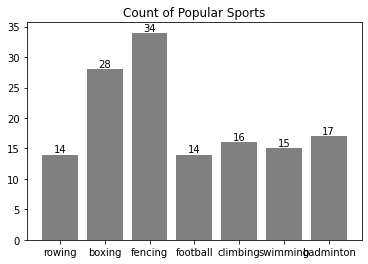

In [14]:
count_list=[]
for sport_name in sport_name_list:
    count_list.append(sports[sport_name])
print(count_list)
plt.bar(range(len(sport_name_list)), count_list,color='gray',tick_label=sport_name_list)
for x,y in zip(range(len(sport_name_list)),count_list):
    plt.text(x, y, y, ha='center', va= 'bottom')
plt.title('Count of Popular Sports')
plt.show()     

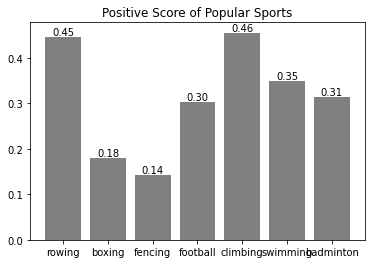

In [15]:
plt.bar(range(len(sport_name_list)), score_list,color='gray',tick_label=sport_name_list)
for x,y in zip(range(len(sport_name_list)),score_list):
    plt.text(x, y, '%.2f' % y, ha='center', va= 'bottom')
plt.title('Positive Score of Popular Sports')
plt.show() 

# The Third question:
## Which professional players have been most talked about recently? - Named Entity Recognition&Named Entity Linking

This implementation is based on [spaCy Entity Linker](https://github.com/egerber/spacy-entity-linker).

In [ ]:
!pip install spacy-entity-linker
!python -m spacyEntityLinker "download_knowledge_base"

In [16]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [17]:
from spacyEntityLinker import EntityLinker
from spacy.language import Language

@Language.factory(
   "entityLinker_1"
)
def create_linker(nlp, name):
      return EntityLinker()

#add to pipeline
nlp.add_pipe('entityLinker_1')

In [18]:
for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
    all_linked_entities = doc._.linkedEntities
    for i in range(len(all_linked_entities)):
        if ('player' or 'athlete' or 'sportsman' or 'sportswoman') in all_linked_entities[i].get_description().lower():
            print(tweet_text)
            all_linked_entities[i].pretty_print()

manika batra crashes out of olympic qualifying event#manikabatra #olympic #tabletennis #india
https://www.wikidata.org/wiki/Q25350367   25350367   Manika Batra                    Indian table tennis player                                                                          
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-09 01 32 46 jw_collectibles vancouver
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-16 14 39 52 lckelt eagle river
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
   th

 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-23 07 14 46 badalsinghgurj2   1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games 
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-23 07 14 46 badalsinghgurj2   1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games 
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 

    in-depth review of the current standings in the #olympic #badminton #qualification  the #racet  0 false2021-03-13 06 51 20 anilkhasa51   1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games 
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-13 07 39 48 pawanba96332506 kurukshetra  1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games 
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-13

 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-13 07 00 00 chinaconsydney sydney
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-18 14 29 49 india_narrative delhi union minister  congratulates 1 on qualifying for the tokyo #olympic games for the 4th con 2021-03-18 14 24 54 worldpentathlon monaco we did it again  uipm secured a full scholarship to join the russian international #olympic university  
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazilian  legend #ronaldinh

 _online  #nstspos competitors at this year's #tokyoolympics and the 2022 #beijing #wintergames will be offered #coronavirus vaccin 0
https://www.wikidata.org/wiki/Q18536342   18536342   competitive player              player of a competitive sport or game                                                               
#nstspos competitors at this year's #tokyoolympics and the 2022 #beijing #wintergames will be offered 
https://www.wikidata.org/wiki/Q18536342   18536342   competitive player              player of a competitive sport or game                                                               
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-07 06 35 04 swatipandey_123     sudha singh
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazi

 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-16 05 04 41 joydeepghosh hyderabad
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
 1  imagine seeing brazilian  legend #ronaldinho competing at another #olympic games  we'll do everything we can to make  0 false2021-03-13 11 23 36 so_hockey limerick
https://www.wikidata.org/wiki/Q39444      39444      Ronaldinho                      Brazilian association football player                                                               
   successful chemist &amp; #olympic medalist dr  james ellis "jimmy" luvalle graduated from #ucla chem &amp; biochem  a new fund in his  0 false2021-03-02 07 22 49 ayesha_am16     #olympic medallist 's biopic #saina
https://www.wikidata.org/wiki/Q368441     368441     James Rodríguez   

text generated by  #it    #mario #wait  #show  #new #sunshine #now  #grumpy  
https://www.wikidata.org/wiki/Q53858110   53858110   Manuel Luís Cafumana            association football player                                                                         
#olympic | #honmex | 0-0 | 13'chance    23 with a header that it's blocked by 's defender     
https://www.wikidata.org/wiki/Q336286     336286     defender                        association football position played near the player's team's own goal                              


In [19]:
import pandas as pd
import numpy as np

data = {}
player=[]
description=[]
counter=[]

for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
#     print(tweet_text)
    all_linked_entities = doc._.linkedEntities
    for i in range(len(all_linked_entities)):
        if ('player' or 'athlete' or 'sportsman' or 'sportswoman') in all_linked_entities[i].get_description().lower():
            
            if ('competitive player'not in all_linked_entities[i].get_label().lower()) and ('end' not in all_linked_entities[i].get_label().lower()) and ('tak' not in all_linked_entities[i].get_label().lower())and ('chess' not in all_linked_entities[i].get_label().lower())and ('quiz' not in all_linked_entities[i].get_label().lower())and ('golf' not in all_linked_entities[i].get_label().lower()):
#                 print(all_linked_entities[i].get_description().lower())

                if all_linked_entities[i].get_description().lower() in description:
                    if all_linked_entities[i].get_label().lower() in player:
                        index_des = description.index(all_linked_entities[i].get_description().lower())
                        index_label = player.index(all_linked_entities[i].get_label().lower())
                        if index_des == index_label :
                            counter[index_des] += 1
                        else:
                            player.append(all_linked_entities[i].get_label().lower())
                            description.append(all_linked_entities[i].get_description().lower())
                            counter.append(1)
                    else:
                        player.append(all_linked_entities[i].get_label().lower())
                        description.append(all_linked_entities[i].get_description().lower())
                        counter.append(1)
                else:
                    player.append(all_linked_entities[i].get_label().lower())
                    description.append(all_linked_entities[i].get_description().lower())
                    counter.append(1)
        

player = np.array(player)
description = np.array(description)
counter = np.array(counter)
idx = counter.argsort()[::-1]
counter = counter[idx]
description = description[idx]
player = player[idx]

print(player)                    
print(description)
print(counter)

['ronaldinho' 'vladislav tretiak' 'walt bellamy' 'james rodríguez'
 'jason kreis' 'manuel luís cafumana' 'manuel luís cafumana' 'zico'
 'saina nehwal' 'homare sawa' 'florinel coman' 'james pantemis'
 'jucimara evangelista dantas' 'mia blichfeldt' 'pusarla venkata sindhu'
 'david ochoa' 'jeff mullins' 'kento momota' 'manuel luís cafumana'
 'pusarla venkata sindhu' 'manuel luís cafumana'
 'eduardo gonçalves de oliveira' 'carmelo anthony'
 'pusarla venkata sindhu' 'manika batra']
['brazilian association football player' 'soviet ice hockey player'
 'american professional basketball player'
 'colombian association football player'
 'association football player and coach' 'association football player'
 'association football player' 'brazilian association football player'
 'indian badminton player' 'japanese association football player'
 'romanian association football player' 'association football player'
 'brazilian basketball player' 'badminton player'
 'indian badminton player' 'american a

In [20]:
data = {
    'player':player,'description':description,'counter':counter
}


df_player = pd.DataFrame(data)

df_player

,player,description,counter
0,ronaldinho,brazilian association football player,76
1,vladislav tretiak,soviet ice hockey player,4
2,walt bellamy,american professional basketball player,3
3,james rodríguez,colombian association football player,2
4,jason kreis,association football player and coach,2
5,manuel luís cafumana,association football player,1
6,manuel luís cafumana,association football player,1
7,zico,brazilian association football player,1
8,saina nehwal,indian badminton player,1
9,homare sawa,japanese association football player,1
